# Income Relationship

Synthetically generated relationship between predictors of `Education`, `Seniority` and response of `Income`. Each predictor individually exhibits a non-linear, sigmoid shape and independently and additively contributes to `Income`.

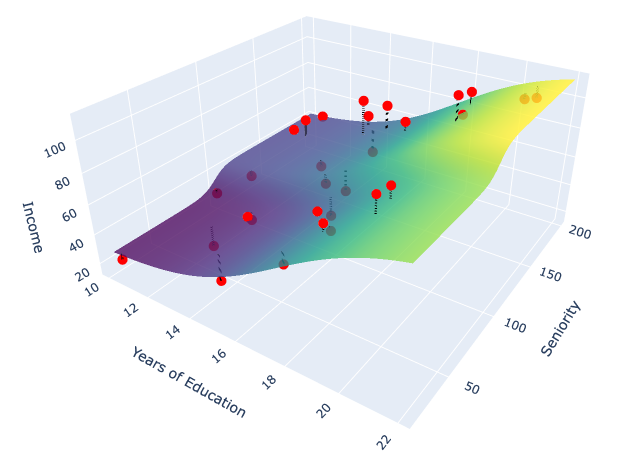

## Imports and settings

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures

In [18]:
np.random.seed(42)

## Synthetic relationship

A synthetic dataset of `IncomeSynthetic` is created which includes the predictors (`education`, `seniority`), their respective income values (`income_ed`, `income_sen`) considered as observations diluted with noise, the respective income values from the true and noiseless relationship (`income_ed_true`, `income_sen_true`) known due to synthetic generation, along with the additive income values (`income`, `income_true`).

### Generating the relationship

In [19]:
# helpers

def sigmoid(x, beta=1, center=0):
    return 1 / (1 + np.exp(-beta * (x - center)))

def bounded_sigmoid(x, beta=1, center=0, a=0, b=1):
    raw_sigmoid = sigmoid(x, beta, center)
    return a + (b - a) * raw_sigmoid

def individual_relationship_f(x, b, c, ymin, ymax):
    return bounded_sigmoid(x, b, c, ymin, ymax)

def combined_relationship_f(x1, x2):
    f1 = individual_relationship_f(x1, ed_beta_0, ed_center, ed_y_min, ed_y_max)
    f2 = individual_relationship_f(x2, sen_beta_0, sen_center, sen_y_min, sen_y_max)
    return f1 + f2

In [20]:
# details

n = 30

## Education
ed_y_min, ed_y_max = 20, 100
ed_beta_0, ed_center = 0.5, 17.5
ed_x_min, ed_x_max = 10, 22
ed_noise_sigma = 10

## Seniority
sen_y_min, sen_y_max = 5, 20
sen_beta_0, sen_center = 0.2, 100
sen_x_min, sen_x_max = 20, 200
sen_noise_sigma = 3

### Bivariate scenario

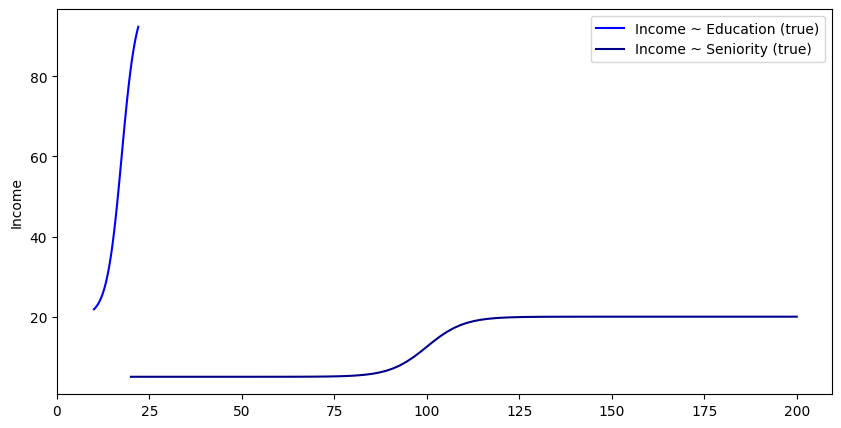

In [21]:
#@title #### Individual contributions

plt.figure(figsize=(10, 5))

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_true = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

plt.plot(xspace, y_true, c="blue", label="Income ~ Education (true)")

xspace = np.linspace(sen_x_min, sen_x_max, 100)
y_true = individual_relationship_f(xspace, sen_beta_0, sen_center, sen_y_min, sen_y_max)

plt.plot(xspace, y_true, c="darkblue", label="Income ~ Seniority (true)")

plt.ylabel("Income")
plt.xlim(left=0)
plt.legend()

plt.show()

In [22]:
#@title #### Combined contribution

x1, x2 = np.linspace(ed_x_min, ed_x_max, 100), np.linspace(sen_x_min, sen_x_max, 100)
X1, X2 = np.meshgrid(x1, x2)

col_relationship1, col_relationship2 = 'cornflowerblue', 'blue'
surface_opacity = 0.75
surface_color_scale = [[0, col_relationship1], [1, col_relationship2]]

Y_true = combined_relationship_f(X1, X2)

true_surface = go.Surface(x=X1, y=X2, z=Y_true,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

fig = go.Figure()
fig.add_trace(true_surface)

scene_setup = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    aspectmode="manual",
    aspectratio=dict(x=1, y=1, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-1.5, z=1)
    )
)

fig.update_layout(
    scene=scene_setup,
    width = 750,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

### Univariate scenario

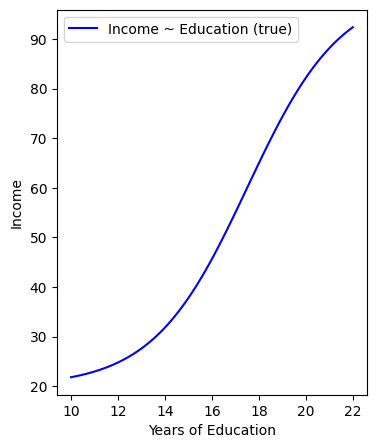

In [23]:
#@title #### Single contributor

fig = plt.figure(figsize=(4, 5))

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_true = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

plt.plot(xspace, y_true, c="blue", label="Income ~ Education (true)")

plt.xlabel("Years of Education")
plt.ylabel("Income")
plt.legend()

plt.show()

## Observation datasets

Construct two datasets where only the naturally observable variables and values are present. One where the individual predictors `education` and `seniority` additively contribute to the income, to be referred to as the `Income` dataset. In the second one, only `education` makes a contribution, to be referred to as the `IncomeSimple`.

In [24]:
education = np.random.uniform(ed_x_min, ed_x_max, n)
seniority = np.random.uniform(sen_x_min, sen_x_max, n)

ed_noise = np.random.normal(0, ed_noise_sigma, size=n)
sen_noise = np.random.normal(0, sen_noise_sigma, size=n)

income = combined_relationship_f(education, seniority) + ed_noise + sen_noise

Income = pd.DataFrame({
    'education': education,
    'seniority': seniority,
    'income': income
})

income_simple = individual_relationship_f(education, ed_beta_0, ed_center, ed_y_min, ed_y_max) + ed_noise

IncomeSimple = pd.DataFrame({
    'education': education,
    'income': income_simple
})

#### `Income`

In [25]:
Income.describe()

,education,seniority,income
count,30.000000,30.000000,30.000000
mean,15.263167,109.352768,58.910305
std,3.388890,59.238784,24.764013
min,10.247014,26.189934,20.932506
25%,12.249662,53.774580,36.432161
50%,14.838911,111.372044,58.143201
75%,17.310021,164.014619,79.798053
max,21.638918,194.525233,116.759390


In [26]:
Income.head()

,education,seniority,income
0,14.494481,129.358073,31.874537
1,21.408572,50.694342,90.341105
2,18.783927,31.709287,73.070548
3,17.183902,190.799397,86.519782
4,11.872224,193.813766,48.237728


#### `IncomeSimple`

In [27]:
IncomeSimple.describe()

,education,income
count,30.000000,30.000000
mean,15.263167,46.517169
std,3.388890,23.432158
min,10.247014,6.895243
25%,12.249662,28.177567
50%,14.838911,41.039375
75%,17.310021,67.199709
max,21.638918,100.344732


In [28]:
IncomeSimple.head()

,education,income
0,14.494481,19.775928
1,21.408572,82.874615
2,18.783927,67.809389
3,17.183902,67.416804
4,11.872224,27.962446


## `IncomeSimple` dataset

The data is displayed in its original scale. Besides the sampled observations that are diluted with zero-mean noise, the true underlying non-linear (synthetic) relationship is highlighted along with the residual lines.

In [29]:
# helper functions

def plot_scatter(x, y, ax, s=20, c="r", label=None):
    ax.scatter(x, y, s=s, c=c, label=label)

def plot_true_function(xspace, true_f, ax, c="b", label=None):
    ax.plot(xspace, true_f, c=c, label=label)

def draw_residual_lines(x, y_obs, y_true, ax, alpha=0.75, color="black"):
    for x_i, y_obs_i, y_true_i in zip(x, y_obs, y_true):
        ax.vlines(x_i, min(y_obs_i, y_true_i), max(y_obs_i, y_true_i), linestyles='dashed', colors=color, alpha=alpha)

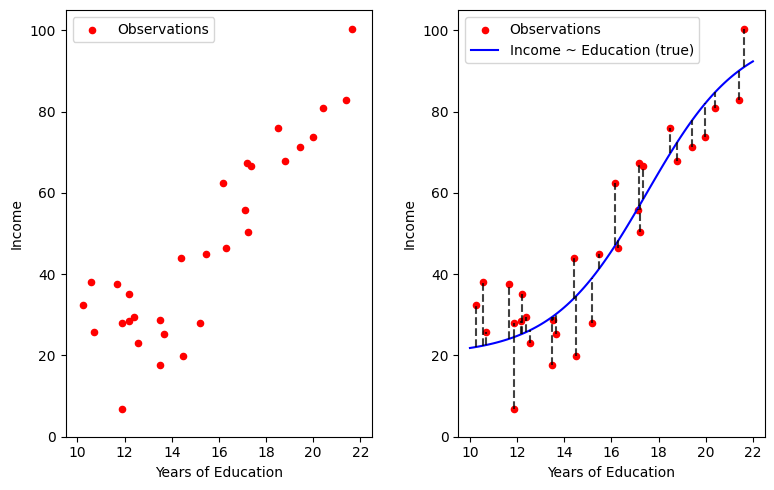

In [30]:
#@title Observations and true relationship

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

x = IncomeSimple['education']
y_obs = IncomeSimple['income']

y_true = individual_relationship_f(x, ed_beta_0, ed_center, ed_y_min, ed_y_max)

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_f = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

# left
ax = axes[0]
plot_scatter(x, y_obs, ax, label="Observations")

# right
ax = axes[1]
plot_scatter(x, y_obs, ax, label="Observations")
plot_true_function(xspace, y_f, ax, label="Income ~ Education (true)")
draw_residual_lines(x, y_obs, y_true, ax)

for ax in axes:
    ax.set_xlabel("Years of Education")
    ax.set_ylabel("Income")
    ax.set_xlim([ed_x_min - 0.5, ed_x_max + 0.5])
    ax.set_ylim(bottom=min(0, ax.get_ylim()[0]))
    ax.legend()

plt.tight_layout()
plt.show()

## `Income` dataset

The data is displayed in its original scale. Besides the sampled observations that are diluted with zero-mean noise, the true underlying non-linear (synthetic) relationship is highlighted along with the residual lines.

In [ ]:
#@title Observations and true relationship

x1, x2 = np.linspace(ed_x_min, ed_x_max, 100), np.linspace(sen_x_min, sen_x_max, 100)
X1, X2 = np.meshgrid(x1, x2)

col_relationship1, col_relationship2 = 'cornflowerblue', 'blue'
surface_opacity = 0.75
surface_color_scale = [[0, col_relationship1], [1, col_relationship2]]

Y_obs = go.Scatter3d(x=Income['education'], y=Income['seniority'], z=Income['income'],
    mode='markers', marker=dict(size=6, color='red', opacity=1), showlegend=False)

Y_true = combined_relationship_f(Income['education'], Income['seniority'])
Y_ff = combined_relationship_f(X1, X2)

true_surface = go.Surface(x=X1, y=X2, z=Y_ff,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

residual_lines = []
for idx, row in Income.iterrows():
    residual_lines.append(
        go.Scatter3d(
            x=[row['education'], row['education']],
            y=[row['seniority'], row['seniority']],
            z=[row['income'], Y_true.iloc[idx]],
            mode='lines', line=dict(color='black', width=5, dash='dash'), showlegend=False))

fig = make_subplots(rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    horizontal_spacing=0, vertical_spacing=0
)

# left
fig.add_trace(Y_obs, row=1, col=1)

# right
fig.add_trace(Y_obs, row=1, col=2)
fig.add_trace(true_surface, row=1, col=2)

for line in residual_lines:
    fig.add_trace(line, row=1, col=2)

scene_setup = dict(
    xaxis_title="Years of Education",
    yaxis_title="Seniority",
    zaxis_title="Income",
    aspectmode="manual",
    aspectratio=dict(x=1, y=1, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-1.5, z=1)
    )
)

fig.update_layout(
    scene=scene_setup,
    scene2=scene_setup,
    width = 1350,
    height = 600,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()